In [16]:
%pip install torchprofile 1>/dev/null

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


In [17]:
import random
from collections import OrderedDict, defaultdict

import numpy as np
import os
import torch
from matplotlib import pyplot as plt
from torch import nn
import trimesh
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torch_geometric.data import Data
from torch.utils.data import random_split, DataLoader
import shutil
from sklearn.model_selection import train_test_split
from torchvision.transforms import *
import glob
from tqdm.auto import tqdm
from torch_geometric.datasets import ShapeNet
import torch_geometric.transforms as T


In [18]:
#ensure reproducibility 
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [21]:
import os
import open3d as o3d
import torch
from torch.utils.data import Dataset

class PointCloudDataset(Dataset):
    def __init__(self, root_dir, num_points=1024, transform=None):
        self.root_dir = root_dir
        self.num_points = num_points
        self.transform = transform
        self.files = []
        self.labels = []

        # Read the PLY files and their labels
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith('.ply'):  # Check for PLY files
                        self.files.append(os.path.join(class_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Load the point cloud file
        pcd = o3d.io.read_point_cloud(self.files[idx])
        point_cloud = np.asarray(pcd.points)  # Get the points as a NumPy array
        if point_cloud.shape[0] > self.num_points:
            point_cloud = point_cloud[np.random.choice(point_cloud.shape[0], self.num_points, replace=False), :]
        elif point_cloud.shape[0] < self.num_points:
            # If there are not enough points, you can either pad or replicate points
            point_cloud = np.pad(point_cloud, ((0, self.num_points - point_cloud.shape[0]), (0, 0)), mode='edge')

        point_cloud = torch.FloatTensor(point_cloud)

        label = self.labels[idx]

        if self.transform:
            point_cloud = self.transform(point_cloud)

        return point_cloud, label
    
    def print_dataset_info(self):
        
        unique_labels, counts = np.unique(self.labels, return_counts=True)
        
        
        print('Label distribution:')
        for label, count in zip(unique_labels, counts):
            print(f'Label {label}: {count} samples')

        


In [20]:
root_dir = './PointClouds'
dataset = PointCloudDataset(root_dir=root_dir)
dataset.print_dataset_info()

Label distribution:
Label 0: 1813 samples
Label 1: 498 samples
Label 2: 651 samples
Label 3: 744 samples
Label 4: 596 samples
Label 5: 460 samples
Label 6: 1597 samples
Label 7: 152 samples
Label 8: 1089 samples


In [13]:
# Split the dataset into training and testing sets
from torch.utils.data import DataLoader, Subset
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create subsets for training and testing
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

print(len(train_dataset))
print(len(test_dataset))


6080
1520


In [22]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
# class VGG(nn.Module):
#   ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

#   def __init__(self) -> None:
#     super().__init__()

#     layers = []
#     counts = defaultdict(int)

#     def add(name: str, layer: nn.Module) -> None:
#       layers.append((f"{name}{counts[name]}", layer))
#       counts[name] += 1

#     in_channels = 3
#     for x in self.ARCH:
#       if x != 'M':
#         # conv-bn-relu
#         add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
#         add("bn", nn.BatchNorm2d(x))
#         add("relu", nn.ReLU(True))
#         in_channels = x
#       else:
#         # maxpool
#         add("pool", nn.MaxPool2d(2))

#     self.backbone = nn.Sequential(OrderedDict(layers))
#     self.classifier = nn.Linear(512, 10)

#   def forward(self, x: torch.Tensor) -> torch.Tensor:
#     # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
#     x = self.backbone(x)

#     # avgpool: [N, 512, 2, 2] => [N, 512]
#     x = x.mean([2, 3])

#     # classifier: [N, 512] => [N, 10]
#     x = self.classifier(x)
#     return x

# model = VGG()

In [23]:
#Switchup to point net
import torch
import torch.nn as nn

class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 1024)
        self.fc4 = nn.Linear(1024, 9)  # Adjust the output size as needed

    def forward(self, x):
        # x shape: (batch_size, num_points, 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.max(x, dim=1)[0]  # Max pooling over the point dimension
        x = self.fc3(x)
        x = self.fc4(x)
        return x

# Example usage:
model = PointNet()
input_tensor = torch.randn(8, 1024, 3)  # Batch size of 8, 1024 points, each with (x, y, z)
output = model(input_tensor)
print(output.shape)  # Should output: torch.Size([8, 10])


torch.Size([8, 9])


In [24]:
import torch.optim as optim

# Initialize your model
model = PointNet()
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Evaluation loop
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get predicted labels
        total += labels.size(0)  # Increment total count
        correct += (predicted == labels).sum().item()  # Increment correct count

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')


Epoch [1/20], Loss: 1.0007
Epoch [2/20], Loss: 0.5915
Epoch [3/20], Loss: 0.5126
Epoch [4/20], Loss: 0.4598
Epoch [5/20], Loss: 0.4426
Epoch [6/20], Loss: 0.4170
Epoch [7/20], Loss: 0.4001
Epoch [8/20], Loss: 0.3904
Epoch [9/20], Loss: 0.3834
Epoch [10/20], Loss: 0.3766
Epoch [11/20], Loss: 0.3743
Epoch [12/20], Loss: 0.3592
Epoch [13/20], Loss: 0.3493
Epoch [14/20], Loss: 0.3437
Epoch [15/20], Loss: 0.3576
Epoch [16/20], Loss: 0.3305
Epoch [17/20], Loss: 0.3546
Epoch [18/20], Loss: 0.3237
Epoch [19/20], Loss: 0.3138
Epoch [20/20], Loss: 0.3038
Accuracy of the model on the test set: 88.55%


In [12]:
import torch
import numpy as np
import open3d as o3d  # To handle PLY files easily
from torchvision import transforms

# Load the PointNet model
model = PointNet()
model.eval()  # Set the model to evaluation mode

# Function to load and preprocess the point cloud
def load_point_cloud(file_path):
    # Load point cloud from PLY file
    pcd = o3d.io.read_point_cloud(file_path)
    points = np.asarray(pcd.points)  # Get the points as a NumPy array
    
    # Ensure the point cloud has the correct number of points (e.g., 1024)
    if points.shape[0] < 1024:
        # Pad with zeros if there are fewer points
        padding = np.zeros((1024 - points.shape[0], 3))
        points = np.vstack((points, padding))
    elif points.shape[0] > 1024:
        # Randomly sample 1024 points if there are more than needed
        indices = np.random.choice(points.shape[0], 1024, replace=False)
        points = points[indices]
    
    # Convert to PyTorch tensor and reshape
    points_tensor = torch.tensor(points, dtype=torch.float32).unsqueeze(0)  # Shape: (1, 1024, 3)
    return points_tensor

# Test the model with a single point cloud
file_path = './PointClouds/faucet/1a5586fc147de3214b35a7d7cea7130_models_model_normalized.ply'  # Replace with your file path
point_cloud_tensor = load_point_cloud(file_path)

# Make predictions
with torch.no_grad():  # No need to compute gradients during testing
    output = model(point_cloud_tensor)

# Get predicted class (assuming softmax output)
predicted_class = torch.argmax(output, dim=1)

print(f'Predicted class: {predicted_class.item()}')



Predicted class: 6


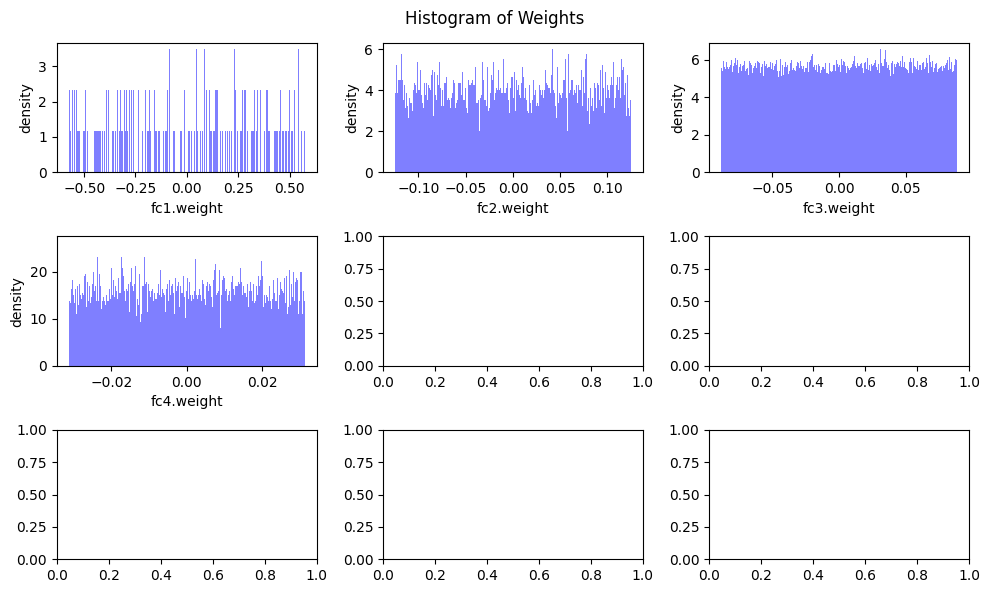

In [13]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)